# Practice: question answering with retrieval

In this homework you will build a retrieval-based question answering system, one component at a time.

_Okay, realistically, there's like, two components, but technically it's one component at a time._


![img](https://www.cs.upc.edu/~mlatifi/index_files/qa-logo.jpg)



There are two parts to this type of systems: a retriever and a generator.
- the retriever subsystem searches for similar texts from a given databse, e.g. wikipedia
- the generator uses the texts found by the retriever to generate an answer in natural language

_this seminar is based on original notebook by [Oleg Vasilev](https://github.com/Omrigan/)_



In [ ]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Part 0: the dataset

Before we train anything, let's take a look at the question answering data that we can use. There are several popilar datasets, e.g. TriviaQA for trivia questions or GSM8K for math. Today's data is Stanford Question Answering Dataset (SQuAD). Given a paragraph of text and a question, our model's task is to select a snippet that answers the question.

We are not going to solve the full task today. Instead, we'll train a model to __select the sentence containing answer__ among several options.

As usual, you are given an utility module with data reader and some helper functions

In [ ]:
%pip install --quiet transformers==4.36.2 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week_extra/retrieval/data.py -O data.py
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad-v2.0.json 2> log

import data
# backup download link: https://www.dropbox.com/s/q4fuihaerqr0itj/squad.tar.gz?dl=1
train, test = data.build_dataset('./squad-v2.0.json')

--2024-07-31 18:11:42--  https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week_extra/retrieval/data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3553 (3.5K) [text/plain]
Saving to: ‘data.py’

data.py             100%[===================>]   3.47K  --.-KB/s    in 0s      

2024-07-31 18:11:42 (46.0 MB/s) - ‘data.py’ saved [3553/3553]



In [ ]:
pid, question, options, correct_indices, wrong_indices = train.iloc[60]
print('QUESTION', question, '\n')
print('TEXT SENTENCES')
for i, cand in enumerate(options):
    print(['[ ]', '[v]'][i in correct_indices], cand)

QUESTION What was the name of Beyoncé's first dance instructor? 

TEXT SENTENCES
[ ] Beyoncé attended St. Mary's Elementary School in Fredericksburg, Texas, where she enrolled in dance classes.
[v] Her singing talent was discovered when dance instructor Darlette Johnson began humming a song and she finished it, able to hit the high-pitched notes.
[ ] Beyoncé's interest in music and performing continued after winning a school talent show at age seven, singing John Lennon's "Imagine" to beat 15/16-year-olds.
[ ] In fall of 1990, Beyoncé enrolled in Parker Elementary School, a music magnet school in Houston, where she would perform with the school's choir.
[ ] She also attended the High School for the Performing and Visual Arts and later Alief Elsik High School.
[ ] Beyoncé was also a member of the choir at St. John's United Methodist Church as a soloist for two years.


### Pre-trained BERT
_(but you guessed it)_

We've already solved quite a few tasks from scratch, training our own embeddings and convolutional/recurrent layers. However, one can often achieve higher quality by using pre-trained models. We will default to the good ol' [BERT](https://arxiv.org/abs/1810.04805), though, you are free to use any [other model](https://huggingface.co/models) as you see fit.


In [ ]:
from transformers import AutoTokenizer, AutoModel, pipeline

model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# just a reminder: here's how it works
dummy_lines = [
    "How old are you?",                                                 # 0
    "In what mythology do two canines watch over the Chinvat Bridge?",  # 1
    "I'm sorry, okay, I'm not perfect, but I'm trying.",                # 2
    "What is your age?",                                                # 3
    "Beware, for I am fearless, and therefore powerful.",               # 4
]

with torch.no_grad():
    batch_tensors = tokenizer(dummy_lines, padding=True, truncation=True, return_tensors="pt")
    out = bert(**batch_tensors)
    token_embs = out.last_hidden_state
    cls_embs = out.pooler_output
    del out


mask = batch_tensors['attention_mask'][..., None].to(torch.float32)
naive_phrase_embs = (token_embs * mask).sum(1) / mask.sum(1)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
naive_phrase_embs.shape

torch.Size([5, 768])

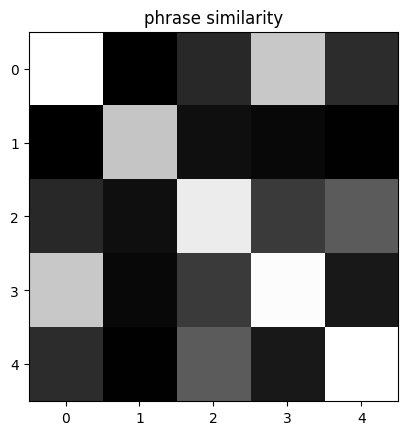

In [ ]:
plt.title('phrase similarity')
plt.imshow((naive_phrase_embs @ naive_phrase_embs.t()).cpu().data.numpy(), interpolation='none', cmap='gray')

As you can see, __the strongest similarity is between lines 0 and 3__. Indeed they correspond to "How old are you?" and "What is your age?"

### Retriever Model (2 points)

Our goal for today is to build a model that measures similarity between question and answer. In particular, it maps both question and answer into fixed-size vectors such that:

Our model is a pair of $V_q(q)$ and $V_a(a)$ - networks that turn phrases into vectors.

__Objective:__ Question vector $V_q(q)$ should be __closer__ to correct answer vectors $V_a(a^+)$ than to incorrect ones $V_a(a^-)$ .

Both vectorizers can be anything you wish. For starters, let's use a couple of dense layers on top of the pre-trained encoder.




In [ ]:
bert.config.hidden_size

768

In [ ]:
xdfg = torch.ones(5)

In [ ]:
xdfg = xdfg.to(device)

In [ ]:
xdfg.device

device(type='cuda', index=0)

In [ ]:
x = None
class Vectorizer(nn.Module):
    def __init__(self, hid_size=256, bert=bert, token = tokenizer):
        """ A small feedforward network on top of pre-trained encoder. 2-3 layers should be enough """
        super().__init__()
        self.bert = bert
        self.tokenizer = tokenizer
        self.hid_size = hid_size

        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(self.bert.config.hidden_size, self.hid_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(self.hid_size, self.hid_size)

        # define a few layers to be applied on top of pre-trained BERT
        # note: please make sure your final layer comes with _linear_ activation

    def forward(self, input_phrases):
        """
        Apply vectorizer. Use dropout and any other hacks at will.
        :param input_phrases: a list of strings, [batch_size]
        :returns: predicted phrase vectors, [batch_size, output_size]

        Note: you may want to use dropouts.
        if self.training:
          <something>

        Note 2: you may also want to use with torch.no_grad to avoid training BERT for your first attempts

        """
        # In fact, please DO use at least 10% dropout!
        input = self.tokenizer(input_phrases, return_tensors='pt', padding=True, truncation=True)
        input = {key: value.to(device) for key, value in input.items()}

        with torch.no_grad():
          output = self.bert(**input)
        cls_embs = output.pooler_output
        if self.training:
          cls_embs = self.dropout(cls_embs)


        cls_embs = self.linear1(cls_embs)
        cls_embs = self.relu(cls_embs)
        cls_embs = self.linear2(cls_embs)
        return cls_embs

question_vectorizer = Vectorizer().to(device)
answer_vectorizer = Vectorizer()
question_vectorizer.train(False)
out1 = question_vectorizer(dummy_lines)
out2 = question_vectorizer(dummy_lines)
assert tuple(out1.shape) == (5, question_vectorizer.hid_size)
assert torch.allclose(out1, out2, atol=1e-5, rtol=0), "Make sure your model disables dropout if training == False"
print("Well done!")

Well done!


In [ ]:
dummy_lines

['How old are you?',
 'In what mythology do two canines watch over the Chinvat Bridge?',
 "I'm sorry, okay, I'm not perfect, but I'm trying.",
 'What is your age?',
 'Beware, for I am fearless, and therefore powerful.']

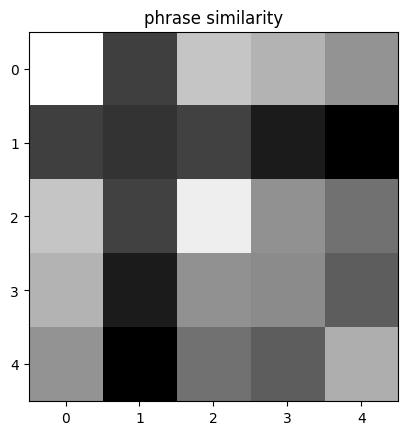

In [ ]:
plt.title('phrase similarity')
plt.imshow((out1 @ out1.t()).cpu().data.numpy(), interpolation='none', cmap='gray')

### Retriever training: minibatches

Our model learns on triples $(q, a^+, a^-)$:
* q - <b>q</b>uestion
* (a+) - correct <b>a</b>nswer
* (a-) - wrong <b>a</b>nswer

Below you will find a generator that samples such triples from data.

In [ ]:
import random

def iterate_minibatches(data, batch_size, shuffle=True, cycle=False):
    """
    Generates minibatches of triples: {questions, correct answers, wrong answers}
    If there are several wrong (or correct) answers, picks one at random.
    """
    indices = np.arange(len(data))
    while True:
        if shuffle:
            indices = np.random.permutation(indices)
        for batch_start in range(0, len(indices), batch_size):
            batch_indices = indices[batch_start: batch_start + batch_size]
            batch = data.iloc[batch_indices]
            questions = batch['question'].values
            correct_answers = np.array([
                row['options'][random.choice(row['correct_indices'])]
                for i, row in batch.iterrows()
            ])
            wrong_answers = np.array([
                row['options'][random.choice(row['wrong_indices'])]
                for i, row in batch.iterrows()
            ])

            yield {
                'questions' : questions,
                'correct_answers': correct_answers,
                'wrong_answers': wrong_answers,
            }
        if not cycle:
            break

In [ ]:
dummy_batch = next(iterate_minibatches(train.sample(3), 3))
print(dummy_batch)

{'questions': array(['What is lisle considered to be as a fabric?',
       'What is the Nickname given to North Carolina?',
       'What did the pope die of?'], dtype=object), 'correct_answers': array(['Cotton lisle is a finely-spun, tightly twisted type of cotton that is noted for being strong and durable.',
       'According to a Forbes article written in 2013 Employment in the "Old North State" has gained many different industry sectors.',
       'He died of stomach cancer on 3 June 1963, four and a half years after his election and two months after the completion of his final and famed encyclical, Pacem in terris.'],
      dtype='<U170'), 'wrong_answers': array(['Colors applied to this yarn are noted for being more brilliant than colors applied to softer yarn.',
       "See the following article summary: science, technology, energy and math, or STEM, industries in the area surrounding North Carolina's capital have grown 17.9 percent since 2001, placing Raleigh-Cary at No.",
       

### Retriever training: loss function (2 points)
We want our vectorizers to put correct answers closer to question vectors and incorrect answers farther away from them. One way to express this is to use is Pairwise Hinge Loss _(aka Triplet Loss)_.

$$ L = \frac 1N \underset {q, a^+, a^-} \sum max(0, \space \delta - sim[V_q(q), V_a(a^+)] + sim[V_q(q), V_a(a^-)] )$$

, where
* sim[a, b] is some similarity function: dot product, cosine or negative distance
* δ - loss hyperparameter, e.g. δ=1.0. If sim[a, b] is linear in b, all δ > 0 are equivalent.


This reads as __Correct answers must be closer than the wrong ones by at least δ.__

![img](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/margin.png)
<center>_image: question vector is green, correct answers are blue, incorrect answers are red_</center>


Note: in effect, we train a Deep Semantic Similarity Model [DSSM](https://www.microsoft.com/en-us/research/project/dssm/).

In [ ]:
batch_size = 4
hid_size = 3
tensor1 = torch.randn(batch_size, hid_size)
tensor2 = torch.randn(batch_size, hid_size)

# Вычисление скалярного произведения
scalar_product = (tensor1 * tensor2).sum(dim=1)

print(scalar_product)


tensor([ 2.4888, -2.3002,  1.6715,  0.7195])


In [ ]:
tensor2[tensor2 < 0] = 0
tensor2

tensor([[1.2073, 0.0000, 0.6163],
        [0.0000, 0.8674, 0.0000],
        [0.0000, 0.0000, 1.4633],
        [0.3909, 0.0000, 0.0000]])

In [ ]:
def similarity(a, b):
    """ Dot product as a similarity function """
    return (a * b).sum(dim=1)

def compute_loss(question_vectors, correct_answer_vectors, wrong_answer_vectors, delta=1.0):
    """
    Compute the triplet loss as per formula above.
    Use similarity function above for  sim[a, b]
    :param question_vectors: float32[batch_size, vector_size]
    :param correct_answer_vectors: float32[batch_size, vector_size]
    :param wrong_answer_vectors: float32[batch_size, vector_size]
    :returns: loss for every row in batch, float32[batch_size]
    Hint: you can compute max(0, *) using torch.relu :)
    """
    result = similarity(question_vectors, wrong_answer_vectors) - similarity(question_vectors, correct_answer_vectors) + delta
    result[result < 0] = 0
    return result

In [ ]:
dummy_v1 = torch.tensor([[0.1, 0.2, -1], [-1.2, 0.6, 1.0]], dtype=torch.float32)
dummy_v2 = torch.tensor([[0.9, 2.1, -6.6], [0.1, 0.8, -2.2]], dtype=torch.float32)
dummy_v3 = torch.tensor([[-4.1, 0.1, 1.2], [0.3, -1, -2]], dtype=torch.float32)


assert np.allclose(similarity(dummy_v1, dummy_v2).data.numpy(), [7.11, -1.84])
assert np.allclose(compute_loss(dummy_v1, dummy_v2, dummy_v3, delta=5.0).data.numpy(), [0.0, 3.88])

Once loss is working, let's train our model by our usual means.

In [ ]:
# we also compute recall: the rate at which a^+ is closer to q than a^-
def get_recall(v_questions, v_correct, v_incorrect):
    # question_vectorizer.train(False)
    # with torch.no_grad():
    #   v_questions = question_vectorizer(questions.tolist())
    #   v_correct = question_vectorizer(correct_answers.tolist())
    #   v_incorrect = question_vectorizer(wrong_answers.tolist())
    print(torch.mean(v_questions))
    correct_is_closer = similarity(v_questions, v_correct) > similarity(v_questions, v_incorrect)
    print(torch.mean(v_incorrect))
    recall = torch.mean(correct_is_closer.to(torch.float32)).item()
    return recall

In [ ]:
# make sure it works
print(get_recall(**dummy_batch))

TypeError: get_recall() got an unexpected keyword argument 'questions'

### Training loop (1 point)

Just as we always do, we can now train DSSM on minibatches and periodically measure recall on validation data.


__Note 1:__ triplet loss training may be very sensitive to the choice of batch size. Small batch size may decrease model quality because there are less negative to consider.

__Note 2:__ here we use the same dataset as __"test set"__ and __"validation (dev) set"__.

In any serious scientific experiment, those must be two separate sets. Validation is for hyperparameter tuning and test is for final eval only.


In [ ]:
train.shape

(58161, 5)

In [ ]:
import pandas as pd
from IPython.display import clear_output
from tqdm import tqdm


# Initialize model, optimizers, anything else you want
model = Vectorizer().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
batch_size = 32



ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=256, cycle=True)
loss_history = []
dev_recall_history = []

In [ ]:
dummy_batch = next(iterate_minibatches(train.sample(3), 3))
dummy_batch

{'questions': array(['What related attraction was at the same site before the Urban Wildlife Centre?',
        'When was the doctrine of Erie Railroad Co. v. Tompkins put into effect?',
        'The Roman Catholic Church objection to Freemasons are based on what?'],
       dtype=object),
 'correct_answers': array(['The Common includes Hawthorns Urban Wildlife Centre on the former site of Southampton Zoo, a paddling pool and several lakes and ponds.',
        'Under the doctrine of Erie Railroad Co. v. Tompkins (1938), there is no general federal common law.',
        'The objections raised by the Roman Catholic Church are based on the allegation that Masonry teaches a naturalistic deistic religion which is in conflict with Church doctrine.'],
       dtype='<U174'),
 'wrong_answers': array(['It has a number of parks and green spaces, the largest being the 148 hectare Southampton Common, parts of which are used to host the annual summer festivals, circuses and fun fairs.',
        'Feder

In [ ]:
type(dummy_batch['questions'])

numpy.ndarray

In [ ]:
# infinite training loop. Stop it manually or implement early stopping
from tqdm import tqdm

for batch in tqdm(iterate_minibatches(train, batch_size=256, cycle=True)):

    # Perform one training step
    v_questions = model(batch['questions'].tolist())
    v_correct = model(batch['correct_answers'].tolist())
    v_incorrect = model(batch['wrong_answers'].tolist())


    loss_t = torch.mean(compute_loss(v_questions, v_correct, v_incorrect))
    opt.zero_grad()
    loss_t.backward()
    opt.step()

    loss_history.append(float(loss_t))


    if len(loss_history) % 50 == 0:

        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)

        with torch.no_grad():
          recall_t = get_recall(v_questions, v_correct, v_incorrect)

        dev_recall_history.append(recall_t)

    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 100
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()


1it [00:04,  4.66s/it]


KeyboardInterrupt: 

In [ ]:
print("Mean recall:", np.mean(dev_recall_history[-10:]))
assert np.mean(dev_recall_history[-10:]) > 0.85, "Please train for at least 85% recall on test set. "\
                                                  "You may need to change vectorizer model for that."
print("Well done!")

Mean recall: 0.750390625


AssertionError: Please train for at least 85% recall on test set. You may need to change vectorizer model for that.

# Retriever evaluation (2 point)

Let's see how well does our model perform on actual question answering.

Given a question and a set of possible answers, pick answer with highest similarity to estimate accuracy.

In [ ]:
# optional: any additional preparations, e.g. build index
# <...>

def select_best_answer(question, possible_answers):
    """
    Predicts which answer best fits the question
    :param question: a single string containing a question
    :param possible_answers: a list of strings containing possible answers
    :returns: integer - the index of best answer in possible_answer
    """
    with torch.no_grad():
      emb_quest = model(question)
    max_elem = None
    max_score = float("-inf")
    for i in possible_answers:
      emb_ans = model(i)
      if similarity(emb_quest, emb_ans) > max_score:
        max_score = similarity(emb_quest, emb_ans)
        max_elem = i

    return max_elem


In [ ]:
test[:1000].shape

(26970, 5)

In [ ]:
predicted_answers = [
    select_best_answer(question, possible_answers)
    for i, (question, possible_answers) in tqdm(test[:1000][['question', 'options']].iterrows(), total=len(test))
]

accuracy = np.mean([
    answer in correct_ix
    for answer, correct_ix in zip(predicted_answers, test['correct_indices'].values)
])
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.65, "we need more accuracy!"
print("Great job!")


 11%|█         | 3000/26970 [03:43<29:48, 13.40it/s]

Accuracy: 0.56967


AssertionError: we need more accuracy!

In [188]:
def draw_results(question, possible_answers, predicted_index, correct_indices):
    print("Q:", question, end='\n\n')
    for i, answer in enumerate(possible_answers):
        print("#%i: %s %s" % (i, '[*]' if i == predicted_index else '[ ]', answer))

    print("\nVerdict:", "CORRECT" if predicted_index in correct_indices else "INCORRECT",
          "(ref: %s)" % correct_indices, end='\n' * 3)

In [190]:
for i in [1, 100, 300, 600, 1200, 2000, 2900]:
    draw_results(test.iloc[i].question, test.iloc[i].options,
                 predicted_answers[i], test.iloc[i].correct_indices)

Q: Which three countries did Beyonce's song "Work It Out" achieve top ten status?

#0: [*] In July 2002, Beyoncé continued her acting career playing Foxxy Cleopatra alongside Mike Myers in the comedy film, Austin Powers in Goldmember, which spent its first weekend atop the US box office and grossed $73 million.
#1: [ ] Beyoncé released "Work It Out" as the lead single from its soundtrack album which entered the top ten in the UK, Norway, and Belgium.
#2: [ ] In 2003, Beyoncé starred opposite Cuba Gooding, Jr., in the musical comedy The Fighting Temptations as Lilly, a single mother whom Gooding's character falls in love with.
#3: [ ] The film received mixed reviews from critics but grossed $30 million in the U.S. Beyoncé released "Fighting Temptation" as the lead single from the film's soundtrack album, with Missy Elliott, MC Lyte, and Free which was also used to promote the film.
#4: [ ] Another of Beyoncé's contributions to the soundtrack, "Summertime", fared better on the US charts.

In [201]:
question = "What is my name?" # your question here!
possible_answers = [
    "My friend is Evgeny",
    "My girlfriend name is Jenny",
    "My name is Evgeny"
    # ^- your options.
]
predicted_answer = select_best_answer(question, possible_answers)

draw_results(question, possible_answers,
             predicted_answer, [0])

Q: What is my name?

#0: [ ] My friend is Evgeny
#1: [ ] My girlfriend name is Jenny
#2: [*] My name is Evgeny

Verdict: INCORRECT (ref: [0])




### Part 2: to prompt a generator (3 points)

You have built a model that can select the most relevant sentence from a text document. However, this is still not the same as question answering - at least not how humans understand it. The full question answering system shoud answer your question in a dialogue - and perhap even let you ask follow-up questions.

In [202]:
# note: you may want to save pre-trained retriever and restart to free memory
import torch
import transformers

model_name = 'TheBloke/Mistral-7B-Instruct-v0.2-GPTQ'  # feel free to choose any other model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tokenizer = transformers.LlamaTokenizer.from_pretrained(model_name, device_map=device)
tokenizer.pad_token_id = tokenizer.eos_token_id
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

  7%|▋         | 1825/26970 [17:37<4:02:44,  1.73it/s]


generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [203]:
pid, question, options, correct_indices, wrong_indices = train.iloc[10]
print('QUESTION', question, '\n')
print('TEXT SENTENCES')
for i, cand in enumerate(options):
    print(['[ ]', '[v]'][i in correct_indices], cand)

QUESTION What was the first album Beyoncé released as a solo artist? 

TEXT SENTENCES
[ ] Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress.
[ ] Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child.
[ ] Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time.
[v] Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".


In [204]:
question_and_info = """
Question: What was the first album Beyoncé released as a solo artist?

Information: Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
"""  # <-- you should un-hardcode this

input_ids = tokenizer.apply_chat_template([
    dict(role='user', content="""You will be given a question and a piece of information that contains the answer. Please reply with a short informal answer to a question based on the information given.""".strip()),
    dict(role='assistant', content="""Okay, what question would you like me to answer?"""),
    dict(role='user', content=question_and_info.strip())], return_tensors='pt').to(device)
# details: https://huggingface.co/docs/transformers/main/en/chat_templating ; only used for chat/instruct models

output_tokens = model.generate(input_ids, attention_mask=torch.ones_like(input_ids),
                               max_new_tokens=64, do_sample=True, temperature=0.8, top_p=0.9)
print(tokenizer.decode(output_tokens[0, input_ids.shape[1]:]))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


The first album Beyoncé released as a solo artist was "Dangerously in Love" in 2003. This album helped establish her as a solo artist on the global stage and earned her five Grammy Awards. It included the Billboard Hot 100 number-one singles "Crazy


### Optional tasks for bonus points

There are many ways to improve our question answering model. Here's a bunch of things you can do to increase your understanding and get bonus points.

### 1.  Hard Negatives (2+ pts)

Not all wrong answers are equally wrong. As the training progresses, _most negative examples $a^-$ will be to easy._ So easy in fact, that loss function and gradients on such negatives is exactly __0.0__. To improve training efficiency, one can __mine hard negative samples__.

Given a list of answers,
* __Hard negative__ is the wrong answer with highest similarity with question,

$$a^-_{hard} = \underset {a^-} {argmax} \space sim[V_q(q), V_a(a^-)]$$

* __Semi-hard negative__ is the one with highest similarity _among wrong answers that are farther than positive one. This option is more useful if some wrong answers may actually be mislabelled correct answers.

* One can also __sample__ negatives proportionally to $$P(a^-_i) \sim e ^ {sim[V_q(q), V_a(a^-_i)]}$$


The task is to implement at least __hard negative__ sampling and apply it for model training.


### 2. Better prompting (2+ pts)

In the previous example, we manually engineer a prompt for an LLM to solve produce an answer. However, by this point you know multiple ways to make LLM do your bidding. In this assignment, you should try at least some of them:
- try few-shot learning with several handcrafted examples (or hand-picked model inputs)
- compare several instruct and/or non-instruct models; for non-instruct models
  - please not that you should not use apply_chat_template for non-instruct models
- provide some means of quality evaluation to compare your approach against the default one

At the minimum, several (10-20) side-by-side examples would do the trick. However, we'd appreciate creative means of evaluation here (crowdsourcing, asking another LM, anything exotic as long as you can explain it).

### 3. Search engine (3+ pts)

Our basic model only selects answers from 2-5 available sentences in paragraph. You can extend it to search over __the whole dataset__. All sentences in all other paragraphs are viable answers.

The goal is to train such a model and use it to __quickly find top-10 answers from the whole set__.

* You can ask such model a question of your own making - to see which answers it can find among the entire training dataset or even the entire wikipedia.
* Searching for top-K neighbors is easier if you use specialized methods: [KD-Tree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) or [HNSW](https://github.com/nmslib/hnswlib).
* This task is much easier to train if you use hard or semi-hard negatives. You can even find hard negatives for one question from correct answers to other questions in batch - do so in-graph for maximum efficiency. See [1.] for more details.
